In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
import pickle
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 


3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [2]:
# gdf = gpd.read_file("../data/iris/contours-iris.gpkg")
# gdf = gdf.to_crs(epsg=4326)
# gdf["fid"] = gdf.index
# gdf["lon"] = gdf.geometry.centroid.x
# gdf["lat"] = gdf.geometry.centroid.y
# gdf = gdf.sort_values(by="code_iris")
# with open("../data/iris/gdf.pickle", "wb") as f:
#     pickle.dump(gdf, f)
with open("../data/iris/gdf.pickle", "rb") as f:
    gdf_france = pickle.load(f)
    geojson=gdf_france.__geo_interface__
    len(gdf_france)

In [275]:
spe_df = pd.read_sql("select id, label, label_long from specialite order by id", config.connection_string, index_col="id")
spe_df.T

id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
label,Psychiatre,Anest,Dermato,Gastro,Gyneco,Opthtalmo,Pediatre,Radio,Dentiste2,Generaliste,Cardio,Chirugien,Endocrino,Geriatre,Neuro,ORL,Pneumo,Radiotherapeuthe,Rhumato,Stomato,Infirmier,Sage-femme,Kine,Podologue,Orthophoniste,Pharmacie,Dentiste
label_long,Psychiatre,Anesthésiste,Dermatologue,Gastro-entérologue,Gynécologue,Opthtalmogue,Pédiatre,Radiologue,Dentiste,Généraliste,Cardiologue,Chirugien,Endocrinologue,Gériatre,Neurologue,Oto-rhino-laryngologiste,Pneumologue,Radiothérapeuthe,Rhumatologue,Stomatologue,Infirmier,Sage-femme,Masseur-Kinésithérapeute,Pédicure-podologue,Orthophoniste,Pharmacie,Chirurgien-dentaire


Documentation

code_commune: il y a plusieurs possibilités :
* le code de la commune sur 5 chiffres, par exemple "06088" pour Nice
* certains anciens code commune sont accepté comme 75101 pour Paris 1er arrondissement
* le département sur 2 chiffres, par exemple "06"
* le code IRIS sur 9 chiffres, par exemple "382050000"
* une liste de code IRIS entre crochet, par exemple \["385480000", "382050000"]
* le code IRIS avec un joker de type "3820%"
* pour la corse utiliser les préfixes 2A ou 2B et non 20, par exemple "2A004"

specialite: voir tableau ci dessus

year: l'année sur 2 chiffre en 20 et 25

source: "PA" pour ps_libreacces ou "PS"

time: 30 ou 45, il est possible d'en faire d'autre mais il faut lancer les calculs

time_type: "HC" ou "HP"

aexp: -0.12 ou -0.1 ou -0.08 ou -0.06 ou -0.04
Pour time==30 aexp: -0.12 ou -0.1 ou -0.08
Pour time==45 aexp: -0.08 ou -0.06
Pour time==60 aexp: -0.06 ou -0.04

Puis appuyer 7 fois sur le bouton Run this cell (bouton play) ou 1 fois sur le bouton Restart (bouton avec double flèche à droite FFW)

L'échelle de couleur est normalisée par rapport aux quantiles de la france entière affichés un peu plus bas

In [298]:
code_commune = "06088" #"75101" #"75056" #"69123" #"38185"  #"06088" "38205" "38548" "2A004" "382050000" ["385480000", "382050000"] "45" "14581" bug
specialite = 21
year = 20 # 20 to 25
source="PA" # PA or PS
time=30 # 30 or 45 or 60
time_type="HC" # HC or HP
norm_colorbar=True
meanw_colorbar=False
aexp = -0.12
if type(code_commune) is list:
    type_code = "LIST"
elif "%" in code_commune and len(code_commune) > 2:
    type_code = "LIKE"
elif len(code_commune) == 2:
    type_code = "LIKE"
    code_commune = code_commune + "%"
elif len(code_commune) == 5:
    type_code = "COM"
elif len(code_commune) == 9:
    type_code = "IRIS"
else:
    raise ValueError(f"Bad {code_commune}")
print(f"Type code: {type_code}")

Type code: COM


In [299]:
sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code='{code_commune}'
order by i.id
"""
commune_nom = None
if type_code=="COM":
    iris_df = pd.read_sql(sql, config.connection_string)
    iriss = iris_df["code"].values
    commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
elif type_code in ["IRIS", "LIKE"]:
    iriss = [code_commune]
elif type_code == "LIST":
    iriss = code_commune
print(f"Found {len(iriss)} iris for {commune_nom}")

if type_code == "LIKE":
    gdf = gdf_france[gdf_france["code_iris"].str.startswith(code_commune[:-1])]
elif len(iriss)>0:
    gdf = gdf_france[gdf_france["code_iris"].isin(iriss)]
else:
    gdf = gdf_france[gdf_france["code_insee"]==code_commune]
    type_code="INSEE"
if commune_nom is None:
    commune_nom=gdf["nom_commune"].iloc[0] if len(gdf) > 0 else None
    print(f"Found {len(gdf)} iris in {commune_nom}")
geojson=gdf.__geo_interface__
print(f"Found {len(gdf)} geo iris for {commune_nom}, type_code: {type_code}")
# gdf_france[gdf_france["nom_commune"].str.startswith("Lyon")].head(100)
gdf.head(2)

Found 146 iris for Nice
Found 146 geo iris for Nice, type_code: COM


,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat
2597,IRIS____0000000060880101,06088,Nice,0101,060880101,Saleya-Château,H,"MULTIPOLYGON (((7.28193 43.69312, 7.28159 43.6...",2597,7.277064,43.695476
4458,IRIS____0000000060880102,06088,Nice,0102,060880102,Vieux Nice-Sainte-Réparate,H,"MULTIPOLYGON (((7.27454 43.69773, 7.27598 43.6...",4458,7.275641,43.697293


In [300]:
sql = f"""
select * from apl.apl_study s
where s.specialite_id={specialite}
and s.year={year}
and s.source='{source}'
and s.time={time}
and s.time_type='{time_type}'
and s.exp={aexp}
order by date desc
limit 1
"""
study_df = pd.read_sql(sql, config.connection_string)
study_df

,year,specialite_id,source,time,time_type,exp,mean,std,q10,q25,q50,q75,q90,min,max,date,key,meanw
0,20,21,PA,30,HC,-0.12,123.512218,73.030086,55.681622,74.27833,102.398301,154.848039,219.433316,0.0,2646.9788,2025-11-18 12:03:57.183662,552804393551,149.07679


In [301]:
key = study_df["key"].iloc[0]
print(f"Study key: {key}")
if type_code == "COM":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and code_commune='{code_commune}'
    """
elif type_code == "IRIS":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and a.iris_string='{code_commune}'
    """
elif type_code == "LIKE":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and a.iris_string like '{code_commune}'
    """
elif type_code == "LIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and a.iris_string in {tuple(code_commune)}
    """
apl = pd.read_sql(text(sql), config.connection_string)
if type_code == "INSEE" or len(apl) == 0:
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    """
    apl = pd.read_sql(sql, config.connection_string)
len(apl)

Study key: 552804393551


146

In [302]:
if len(apl[apl["iris_string"]=="180331201"])>0 and len(apl[apl["iris_string"]=="181740000"])>0:
    apl.loc[apl["iris_string"]=="180331201","apl"]=apl[apl["iris_string"]=="181740000"]["apl"].iloc[0]
if len(apl[apl["iris_string"]=="140110000"])>0:
    apl.loc[apl["iris_string"]=="140110000","iris_string"]="145810000"

In [303]:
apl["code_iris"]=apl["iris_string"]
gdf = gdf.merge(apl, on="code_iris", how="left", suffixes=('', '_dest')).copy()
gdf["pretty"]=gdf["apl"].fillna(0).apply(lambda x: round(x, 0)).astype(np.int32)
qmax = study_df["max"].iloc[0] if study_df["max"].iloc[0] != 0 else 1.0
meanw = 0
try:
    meanw = study_df["meanw"].iloc[0]
except:
    pass
if meanw_colorbar:
    q50 = meanw
    q25 = q50 / 2
    q10 = q50 / 5
    q90 = q50 * 2
    q75 = (q90 + q50) / 2
else:
    q90 = study_df["q90"].iloc[0] if study_df["q90"].iloc[0] != 0 else 1.0
    q75 = study_df["q75"].iloc[0] if study_df["q75"].iloc[0] != 0 else 0.0
    q50 = study_df["q50"].iloc[0] if study_df["q50"].iloc[0] != 0 else q75
    q25 = study_df["q25"].iloc[0] if study_df["q25"].iloc[0] != 0 else q50
    q10 = study_df["q10"].iloc[0] if study_df["q10"].iloc[0] != 0 else q25
gdf["pop_ajustee"]=gdf['pop_gp']
gdf["apl_clip"]=gdf["apl"].clip(0,q90)
meanw_colorbar, meanw, q50

(False, 149.07678983452158, 102.39830054641315)

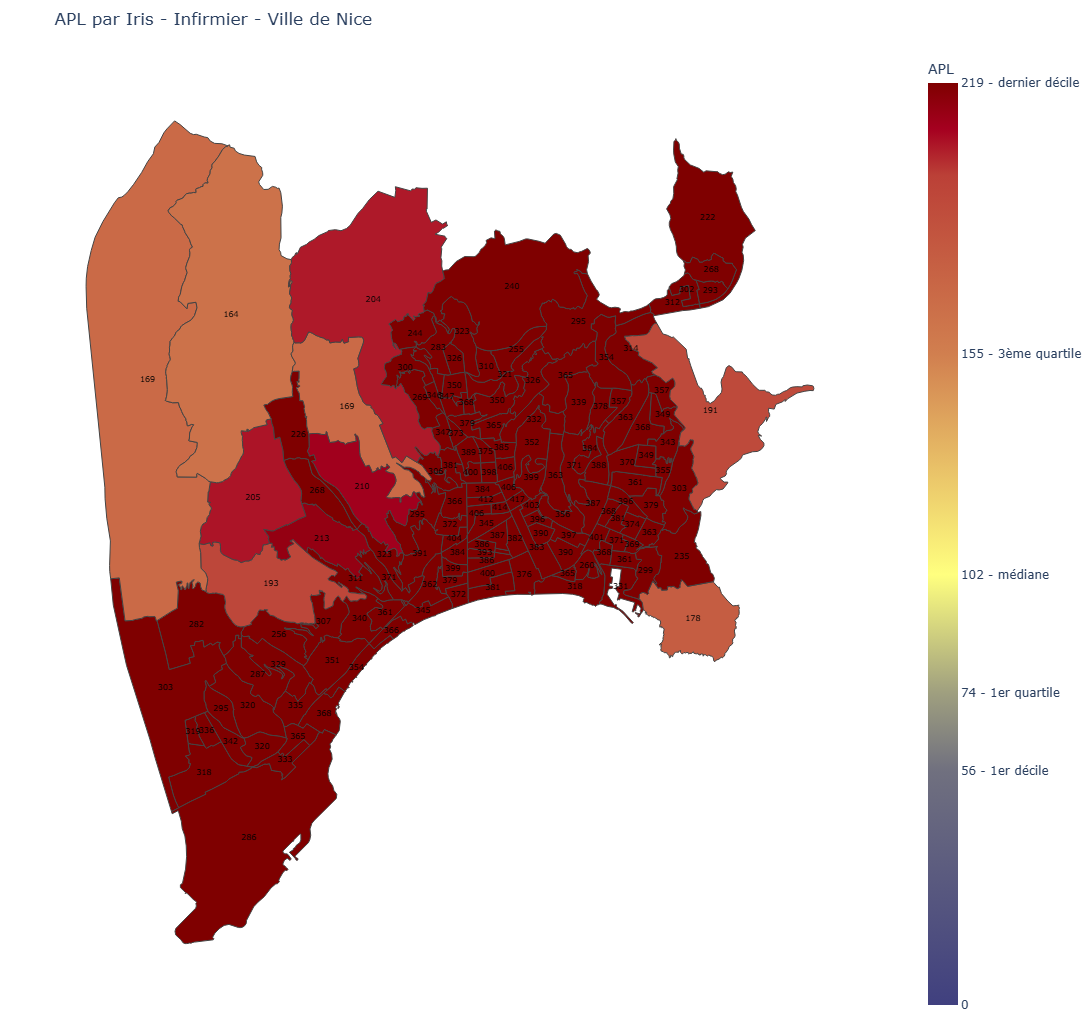

In [304]:
show_label=len(gdf) < 150
fig = go.Figure()
fig.add_trace(go.Choropleth(
    geojson=geojson,
    locations=gdf["fid"],
    z=gdf["apl_clip" if norm_colorbar else "apl"],
    zmin=0,
    zmax=q90 if norm_colorbar else None,
    text=gdf.apply(
        lambda row: f"Commune: {row["nom_commune"]}<br>Iris: {row["code_iris"]}<br>Nom Iris: {row['nom_iris']}<br>APL: {row['apl']:.1f}<br>Médiane APL: {(row["apl"]-q50)*100/(q50+0.001):+.0f}% ({q50:.1f})<br>Moyenne pondérée APL: {(row["apl"]-meanw)*100/(meanw+0.001):+.0f}% ({meanw:.1f})<br>Nb ETP: {row['nb']:.1f}<br>Population: {row['pop']:.0f}<br>Population ajustée: {row['pop_ajustee']:.0f}<br>Population alentour: {row['swpop']:.0f}<br>APL local: {row['R']:.1f} ({row['R']*100/(row['apl']+1e-5):.0f}% APL)",
        axis=1
    ),
    hoverinfo="text",
    showscale=True,
    # colorscale="Portland",
    colorbar={"title": "APL",
              "tickvals": [0, q10, q25, q50, q75, q90] if norm_colorbar else None,
              "ticktext": ['0', f'{q10:.0f} {"" if meanw_colorbar else "- 1er décile"}', f'{q25:.0f} {"" if meanw_colorbar else "- 1er quartile"}', f'{q50:.0f} - {"moyenne" if meanw_colorbar else "médiane"}', f'{q75:.0f} {"" if meanw_colorbar else "- 3ème quartile"}', f'{q90:.0f} {"" if meanw_colorbar else "- dernier décile"}'] if norm_colorbar else None,
             },
    colorscale=[[0.0, "rgb(64,64,127)"],
                [q10*1.0/q90 if norm_colorbar else 0.1, "rgb(112,112,127)"],
                [q25*1.0/q90 if norm_colorbar else 0.25, "rgb(159,159,127)"],
                [q50*1.0/q90 if norm_colorbar else 0.5, "rgb(255,255,127)"],
                [q75*1.0/q90 if norm_colorbar else 0.75, "rgb(209,127,79)"],
                [0.90, "rgb(187,64,55)"],
                [0.95, "rgb(165,0,32)"],
                [1.0, "rgb(127,0,0)"]
                # [q90/q90, "rgb(187,64,55)"],
                # [0.99, "rgb(165,0,32)"],
                # [1.0, "rgb(127,0,0)"]
               ]
))
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

if show_label:
    fig.add_trace(go.Scattergeo(
        lon=gdf["lon"],
        lat=gdf["lat"],
        text=gdf["pretty"].astype(str),
        mode="text",
        textfont=dict(color="black", size=8),
        hoverinfo="skip",
        showlegend=False,
        # uniformtext_minsize=8,
        # uniformtext_mode='hide',
        marker=dict(
                color='#99ff99',
                size=8,
                line=dict(
                    color='#006600',
                    width=2
                )
            ),
    ))
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        center={"lat": center_lat, "lon": center_lon},
        fitbounds="locations",
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        visible=False,
    ),
    title=f"APL par Iris - {spe_df.loc[specialite]["label_long"]} - {"Ville de" if len(code_commune) != 3 else "Département"} {commune_nom if len(code_commune) != 3 else code_commune[:-1]}",
    height=1000,
    width=1200,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

In [305]:
gdf["apl"].describe().apply("{0:.0f}".format)

count    146
mean     337
std       59
min      164
25%      310
50%      355
75%      379
max      417
Name: apl, dtype: object

In [306]:
pio.write_html(fig, file=f"out/apl_{code_commune.replace("%","")}_{source}_{time}_{time_type}_{aexp}{'' if norm_colorbar else '_nonorm'}_{spe_df.loc[specialite].iloc[0]}_{year}.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})

In [307]:
gdf.columns

Index(['cleabs', 'code_insee', 'nom_commune', 'iris', 'code_iris', 'nom_iris',
       'type_iris', 'geometry', 'fid', 'lon', 'lat', 'year', 'specialite',
       'iris_dest', 'iris_string', 'type_iris_dest', 'nb', 'apl', 'ap',
       'accessibilite_weight', 'R', 'wpop', 'swpop', 'pop_gp', 'pop',
       'iris_label', 'dept', 'code_commune', 'commune_label', 'study_key',
       'meanw', 'pretty', 'pop_ajustee', 'apl_clip'],
      dtype='object')

In [308]:
gdf["sumw"]=gdf["apl"]*gdf["pop_gp"]
sum_pop = np.sum(gdf["pop_gp"])
gdf["meanw"]=gdf["sumw"]*len(gdf)/sum_pop
np.mean(gdf["meanw"])

335.0782529968786